In [1]:
import pandas as pd
import numpy as np
import warnings
import pyodbc
import random
import os
import matplotlib.pyplot as plt

warnings.filterwarnings(action = 'ignore')

In [2]:
conn_pcor = pyodbc.connect('driver={Oracle in OraClient18Home1};dbq=PCOR;uid=EF0SEL;pwd=EF0SEL#076')
conn_quant = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=quant;uid=index;pwd=samsung@00')
conn_wisefn = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=wisefn;uid=index;pwd=samsung@00')

In [3]:
os.chdir("..")
os.chdir("..")

os.chdir('00_data')

#df_const = pd.read_json('230927_index_constituent.json')
df_prc_raw = pd.read_json('230927_stk_prc_daily.json')
#df_turnover = pd.read_json('230927_stk_turnover.json')
#df_sector = pd.read_json('230927_stk_sector.json')
#df_mktcap = pd.read_json('230927_stk_mktcap.json')
#df_turnover_daily = pd.read_json('231011_stk_turnover_daily.json')

os.chdir("..")
os.chdir('02_Trading Strategies')
os.chdir('231026_유전 알고리즘을 활용한 페어트레이딩')

In [4]:
sector_code = 'IKS013'

In [5]:
sql_dt = f'''
        SELECT TRD_DT, CLOSE_PRC
        FROM TS_IDX_DAILY
        WHERE 1=1
        AND SEC_CD = '{sector_code}'
        AND TRD_DT > '20091231'
        ORDER BY TRD_DT ASC
'''

df_dt = pd.read_sql(sql_dt, conn_wisefn)

In [6]:
df_dt['TRD_DT'] =  pd.to_datetime(df_dt['TRD_DT'])
df_dt['M'] = df_dt['TRD_DT'].dt.to_period('M')
dt_m = [max(df_dt[df_dt['M']==p]['TRD_DT']) for p in df_dt['M'].unique()]
dt_m = [int(x.strftime('%Y%m%d')) for x in dt_m]

In [7]:
len(dt_m)

167

In [8]:
i = int(np.round(len(dt_m)*0.60,0))
base_d = dt_m[i]
train_begin_dt = dt_m[0]
train_end_dt = base_d

In [9]:
train_end_dt

20180531

In [10]:
sql_const = f'''
            SELECT TRD_DT, CONCAT('A',STK_CD) COMP_CD, STK_NM_KOR COMP_NM
            FROM TS_STK_ISSUE
            WHERE 1=1
            AND KS200_TYP = 1
            AND TRD_DT = '{base_d}'
            AND KSC_CD = '{sector_code}'
'''

df_const = pd.read_sql(sql_const, conn_wisefn)

In [11]:
df_train = df_prc_raw.copy()
df_train = df_train[df_train['TRD_DT'] >= train_begin_dt]
df_train = df_train[df_train['TRD_DT'] <= train_end_dt]
df_train = df_train[df_train['COMP_CD'].isin(df_const['COMP_CD'])]
df_train = df_train.sort_values(by = ['TRD_DT','COMP_CD'])
stk_list = sorted(list(set(df_train['COMP_CD'])))


df_train = df_train.pivot(index = 'TRD_DT', columns = 'COMP_CD')
df_train = df_train.droplevel(axis = 1, level = 0)
df_train = df_train[stk_list]

In [12]:
df_test = df_prc_raw.copy()
df_test = df_test[df_test['TRD_DT'] >= train_end_dt]
#df_test = df_prc[df_prc['TRD_DT'] <= train_end_dt]
df_test = df_test[df_test['COMP_CD'].isin(df_const['COMP_CD'])]
df_test = df_test.sort_values(by = ['TRD_DT','COMP_CD'])

df_test = df_test.pivot(index = 'TRD_DT', columns = 'COMP_CD')
df_test = df_test.droplevel(axis = 1, level = 0)
df_test = df_test[stk_list]

In [13]:
df_train.shape, df_test.shape

((2059, 15), (1316, 15))

In [14]:
def objective_func(df, params):
    
    #stk_list = sorted(list(set(df['COMP_CD'])))
    
    params_period = params[0]
    params_init = params[1]
    params_exit = params[2]
    params_wt = params[3:]

    df_sp = df * params_wt
    df_sp = df_sp.sum(axis=1)
    
    df_sp_norm = (df_sp - df_sp.rolling(params_period).mean())/df_sp.rolling(params_period).std()
    df_sp_norm.dropna(axis=0, inplace=True)
    
    init_dt = []
    exit_dt = []
    init_yn = 0
    for i in range(len(df_sp_norm)):
        if init_yn == 0:
            if df_sp_norm.iloc[i] < params_init:
                init_dt.append(df_sp_norm.index[i])
                init_yn = 1
        
        elif init_yn == 1:
            if df_sp_norm.iloc[i] > params_exit:
                exit_dt.append(df_sp_norm.index[i])
                init_yn = 0
        
    if len(init_dt) > len(exit_dt):
        if len(init_dt) - len(exit_dt) > 1:
            print("error")
        else:
            init_dt = init_dt[:-1]
    
    ret_list = []
    cum_ret = 1
    for i in range(len(init_dt)):
        dt_1 = init_dt[i]
        dt_2 = exit_dt[i]
        
        prc_1 = df.loc[dt_1]
        prc_2 = df.loc[dt_2]
        
        ret = prc_2/prc_1 - 1
        ret = (ret * params_wt).sum()
        ret_list.append(ret)
        cum_ret *= (1+ret)
    
    return cum_ret

In [15]:
def generate_weight(length):
    
    pos_len = random.randint(1,length - 1)
    neg_len = length - pos_len
    
    pos_wt = []
    for i in range(pos_len):
        p = random.uniform(0,1)
        pos_wt.append(p)
    
    pos_wt = [x/sum(pos_wt) for x in pos_wt]
    
    neg_wt = []
    for i in range(neg_len):
        n = random.uniform(0,1)
        neg_wt.append(n)
    
    neg_wt = [-x/sum(neg_wt) for x in neg_wt]
    
    wt = pos_wt + neg_wt
    
    random.shuffle(wt)
    
    return wt  
        

def generate_params(length):
    
    params_period = random.randint(20,20*36)
    params_init = random.uniform(-4,0)
    params_exit = random.uniform(0,4)
    
    params_wt = generate_weight(length)
    
    params = [params_period, params_init, params_exit, *params_wt]
            
    return params
    

In [16]:
def generate_pop(size, length):
    population = []
    
    for i in range(size):
        pop = generate_params(length)
        population.append(pop)
    
    return population

In [17]:
def compute_performance(df, population):
    
    obj_list = []
    for individual in population:
        obj = objective_func(df, individual)
        obj_list.append([individual,obj])
    
    pop_sorted = sorted(obj_list, key=lambda x: x[1], reverse=True)
    
    return pop_sorted

In [18]:
def select_survivors(population_sorted, best_sample, lucky_few, length):
    
    next_gen = []
    
    for i in range(best_sample):
        if population_sorted[i][1] > 0:
            next_gen.append(population_sorted[i][0])
    
    lucky_index = np.random.choice(list(range(len(population_sorted))), lucky_few, replace=False)
    for i in lucky_index:
        next_gen.append(population_sorted[i][0])
    
    next_gen_2 = []
    for item in next_gen:
        if item not in next_gen_2:
            next_gen_2.append(item)
    
    
    while len(next_gen_2) < best_sample + lucky_few:
        next_gen_2.append(generate_params(length))
        
    random.shuffle(next_gen_2)
    
    return next_gen_2

In [49]:
def create_child(param1, param2):
    
    r1 = random.random()
    r2 = random.random()
    r3 = random.random()
    
    if r1 < 0.5:
        params_period = param1[0]
    else:
        params_period = param2[0]
        
    if r2 < 0.5:
        params_init = param1[1]
    else:
        params_init = param2[1]
        
    if r3 < 0.5:
        params_exit = param1[2]
    else:
        params_exit = param2[2]
    

    temp = random.random()

    if temp < 0.5:
        params_wt = param1[3:]
    else:
        params_wt = param2[3:]

    child = [params_period, params_init, params_exit, *params_wt]
            
    return child


def create_children(df, population, n_child):
    
    k = 1
    children = []
    
    fitness = [objective_func(df, x) for x in population]
    fitness_2 = [x if x >= 0 else 0 for x in fitness]
    
    prob = [x/sum(fitness_2) for x in fitness_2]
    

    while k < n_child:
        try:
            sample = np.random.choice(list(range(len(prob))), 2, replace=False, p = prob)
        except:
            sample = np.random.choice(list(range(len(prob))), 2, replace=False)
        parents = [population[sample[0]], population[sample[1]]]
        
        child = create_child(parents[0], parents[1])
        children.append(child)
        
        k += 1
    
    return children

In [20]:
def mutation1(param, prob):
    
    r1 = random.random()
    r2 = random.random()
    r3 = random.random()
    
     
    if r1 < prob:
        param_period = random.randint(20,20*36)
    else:
        param_period = param[0]
           
    if r2 < prob:
        param_init = random.uniform(-4,0)
    else:
        param_init = param[1]
        
    if r3 < prob:
        param_exit = random.uniform(0,4)
    else:
        param_exit = param[2]
        
        
    param_mutate = [param_period, param_init, param_exit, *param[3:]]
    
    return param_mutate


def mutation2(param, prob):
    
    r1 = random.random()
    
    if r1 < prob:
        temp_pos = [random.uniform(0,1) if x >= 0 else 0 for x in param[3:]]
        temp_neg = [-random.uniform(0,1) if x < 0 else 0 for x in param[3:]]
        temp_pos = [x/sum(temp_pos) for x in temp_pos]
        temp_neg = [-x/sum(temp_neg) for x in temp_neg]
        param_wt = [x+y for (x,y) in zip(temp_pos, temp_neg)]
    
    else:
        param_wt = param[3:]
        
    
    param_mutate = param[:3] + param_wt
    
    return param_mutate


def mutation3(param, prob):
    
    r1 = random.random()
    
    param_wt = param[3:]
    
    if r1 < prob:
        random.shuffle(param_wt)

    
    param_mutate = param[:3] + param_wt
    
    return param_mutate


def mutation4(param, prob):
    
    r1 = random.random()
    
    if r1 < prob:
        temp = [x if random.uniform(-1,1) >= 0 else -x for x in param[3:]]
        temp_pos = [x if x >= 0 else 0 for x in temp]
        temp_neg = [x if x < 0 else 0 for x in temp]
        temp_pos = [x/sum(temp_pos) for x in temp_pos]
        temp_neg = [-x/sum(temp_neg) for x in temp_neg]
        param_wt = [x+y for (x,y) in zip(temp_pos,temp_neg)]
    else:
        param_wt = param[3:]
        
    
    param_mutate = param[:3] + param_wt
    
    return param_mutate


################################################
def mutate_pop(population, prob1, prob2, prob3, prob4):
    
    for i in range(len(population)):
            population[i] = mutation1(population[i], prob1)
            population[i] = mutation2(population[i], prob2)
            population[i] = mutation3(population[i], prob3)
            population[i] = mutation3(population[i], prob4)
    
    return population

In [21]:
n_generation = 100
population = 100
best_sample = 25
lucky_few = 25
prob1 = 0.01
prob2 = 0.05
prob3 = 0.05
prob4 = 0.1
param_length = len(stk_list)

In [22]:
pop = generate_pop(size = population, length = param_length)

best_gene = []
best_perf = []
for g in range(n_generation):
    
    pop_sorted = compute_performance(df_train, pop)
    
    survivors = select_survivors(pop_sorted, best_sample, lucky_few, param_length)
    
    children = create_children(df_train, survivors, population)
    
    new_generation = mutate_pop(children, prob1, prob2, prob3, prob4)
    #new_generation = mutate_pop_2(children, prob)
    
    pop = new_generation
    best_gene.append(pop_sorted[0][0])
    best_perf.append(pop_sorted[0][1])
    
    print(f'====== {g}th generation ends ======')
    print(pop_sorted[0])

====== 0th generation ends ======
[[466, -1.564092089627867, 3.9569341059195637, 0.067775327742689, -0.05074697600293907, -0.1294342368452525, -0.07756182739736293, 0.19397628644878195, -0.10571783440578224, -0.11956070555799332, -0.024834629951637356, -0.12458954056974547, 0.738248385808529, -0.06498815352318126, -0.08931886405132564, -0.049026861057877826, -0.0760872562822478, -0.08813311435465461], 3.0770311489743243]
====== 1th generation ends ======
[[466, -1.564092089627867, 3.9569341059195637, 0.067775327742689, -0.05074697600293907, -0.1294342368452525, -0.07756182739736293, 0.19397628644878195, -0.10571783440578224, -0.11956070555799332, -0.024834629951637356, -0.12458954056974547, 0.738248385808529, -0.06498815352318126, -0.08931886405132564, -0.049026861057877826, -0.0760872562822478, -0.08813311435465461], 3.0770311489743243]
====== 2th generation ends ======
[[466, -1.5967300306978438, 3.9569341059195637, 0.067775327742689, -0.05074697600293907, -0.1294342368452525, -0.077

====== 20th generation ends ======
[[471, -0.8085780745809958, 3.169817871316826, 0.2849821859102176, -0.028313528697589123, -0.03009342667112126, -0.009231233415125521, 0.0350297042877385, -0.04214143638032583, -0.1427416414934722, -0.12402345842591757, -0.030327856417456688, 0.6799881098020438, -0.15185889027090613, -0.10923050896014433, -0.08847479531418923, -0.1408539445610663, -0.10270927939268572], 4.167222216154013]
====== 21th generation ends ======
[[471, -0.8085780745809958, 3.169817871316826, 0.2849821859102176, -0.028313528697589123, -0.03009342667112126, -0.009231233415125521, 0.0350297042877385, -0.04214143638032583, -0.1427416414934722, -0.12402345842591757, -0.030327856417456688, 0.6799881098020438, -0.15185889027090613, -0.10923050896014433, -0.08847479531418923, -0.1408539445610663, -0.10270927939268572], 4.167222216154013]
====== 22th generation ends ======
[[471, -0.8085780745809958, 3.169817871316826, 0.2849821859102176, -0.028313528697589123, -0.03009342667112126,

====== 40th generation ends ======
[[537, -2.602479063660248, 3.343428942252026, -0.12458954056974547, 0.067775327742689, -0.049026861057877826, -0.1294342368452525, 0.19397628644878195, -0.11956070555799332, -0.10571783440578224, -0.024834629951637356, -0.08813311435465461, 0.738248385808529, -0.06498815352318126, -0.05074697600293907, -0.07756182739736293, -0.0760872562822478, -0.08931886405132564], 4.288379473641426]
====== 41th generation ends ======
[[537, -2.602479063660248, 3.492531532963442, -0.12458954056974547, 0.067775327742689, -0.049026861057877826, -0.1294342368452525, 0.19397628644878195, -0.11956070555799332, -0.10571783440578224, -0.024834629951637356, -0.08813311435465461, 0.738248385808529, -0.06498815352318126, -0.05074697600293907, -0.07756182739736293, -0.0760872562822478, -0.08931886405132564], 4.288379473641426]
====== 42th generation ends ======
[[537, -2.602479063660248, 3.492531532963442, -0.12458954056974547, 0.067775327742689, -0.049026861057877826, -0.1294

====== 60th generation ends ======
[[498, -0.9137758714274229, 3.492531532963442, 0.067775327742689, -0.05074697600293907, -0.1294342368452525, -0.07756182739736293, 0.19397628644878195, -0.10571783440578224, -0.11956070555799332, -0.024834629951637356, -0.12458954056974547, 0.738248385808529, -0.06498815352318126, -0.08931886405132564, -0.049026861057877826, -0.0760872562822478, -0.08813311435465461], 3.9679741230647556]
====== 61th generation ends ======
[[498, -0.9137758714274229, 3.492531532963442, 0.067775327742689, -0.05074697600293907, -0.1294342368452525, -0.07756182739736293, 0.19397628644878195, -0.10571783440578224, -0.11956070555799332, -0.024834629951637356, -0.12458954056974547, 0.738248385808529, -0.06498815352318126, -0.08931886405132564, -0.049026861057877826, -0.0760872562822478, -0.08813311435465461], 3.9679741230647556]
====== 62th generation ends ======
[[499, -0.9047570261705511, 3.864108180092856, 0.067775327742689, -0.05074697600293907, -0.1294342368452525, -0.0

====== 80th generation ends ======
[[499, -0.6017249602644084, 3.769637126858694, 0.067775327742689, -0.05074697600293907, -0.1294342368452525, -0.07756182739736293, 0.19397628644878195, -0.10571783440578224, -0.11956070555799332, -0.024834629951637356, -0.12458954056974547, 0.738248385808529, -0.06498815352318126, -0.08931886405132564, -0.049026861057877826, -0.0760872562822478, -0.08813311435465461], 3.986570973677416]
====== 81th generation ends ======
[[499, -0.5922214053714696, 3.4379427527464945, 0.067775327742689, -0.05074697600293907, -0.1294342368452525, -0.07756182739736293, 0.19397628644878195, -0.10571783440578224, -0.11956070555799332, -0.024834629951637356, -0.12458954056974547, 0.738248385808529, -0.06498815352318126, -0.08931886405132564, -0.049026861057877826, -0.0760872562822478, -0.08813311435465461], 3.986570973677416]
====== 82th generation ends ======
[[498, -0.5922214053714696, 3.769637126858694, 0.067775327742689, -0.05074697600293907, -0.1294342368452525, -0.07

In [37]:
def simulation_func(df, params):
    
    #stk_list = sorted(list(set(df['COMP_CD'])))
    
    params_period = params[0]
    params_init = params[1]
    params_exit = params[2]
    params_wt = params[3:]

    df_sp = df * params_wt
    df_sp = df_sp.sum(axis=1)
    
    df_sp_norm = (df_sp - df_sp.rolling(params_period).mean())/df_sp.rolling(params_period).std()
    df_sp_norm.dropna(axis=0, inplace=True)
    
    init_dt = []
    exit_dt = []
    init_yn = 0
    for i in range(len(df_sp_norm)):
        if init_yn == 0:
            if df_sp_norm.iloc[i] < params_init:
                init_dt.append(df_sp_norm.index[i])
                init_yn = 1
        
        elif init_yn == 1:
            if df_sp_norm.iloc[i] > params_exit:
                exit_dt.append(df_sp_norm.index[i])
                init_yn = 0
        
    if len(init_dt) > len(exit_dt):
        if len(init_dt) - len(exit_dt) > 1:
            print("error")
        else:
            init_dt = init_dt[:-1]
    
    ret_list = []
    long_ret_list = []
    short_ret_list = []
    cum_ret = 1
    for i in range(len(init_dt)):
        dt_1 = init_dt[i]
        dt_2 = exit_dt[i]
        
        prc_1 = df.loc[dt_1]
        prc_2 = df.loc[dt_2]

        
        ret = prc_2/prc_1 - 1
        ret_ls = (ret * params_wt).sum()
        ret_list.append(ret_ls)        
        cum_ret *= (1+ret_ls)
        
        long_wt = [x if x >= 0 else 0 for x in params_wt]
        long_ret = (ret * long_wt).sum()
        long_ret_list.append(long_ret)
        
        short_wt = [x if x < 0 else 0 for x in params_wt]
        short_ret = (ret * short_wt).sum()
        short_ret_list.append(short_ret)
        
        
    
    return cum_ret, init_dt, exit_dt, ret_list, long_ret_list, short_ret_list

In [38]:
result_train = simulation_func(df_train,pop_sorted[0][0])

In [39]:
result_test = simulation_func(df_test,pop_sorted[0][0])

In [40]:
pop_sorted[0][0]

[498,
 -0.5922214053714696,
 0.317491089231404,
 -0.02584772404940214,
 0.44696113125413506,
 0.12491188781947864,
 0.10785807220749169,
 -0.0196536918148939,
 -0.19621676931016255,
 -0.058672142598269965,
 0.02221343546080714,
 0.06358903787732338,
 0.23446643538076412,
 -0.19865561810536378,
 -0.013518326886972545,
 -0.24461586466562826,
 -0.2336146111452919,
 -0.0092052514240149]

In [41]:
pd.DataFrame([stk_list, pop_sorted[0][0][3:]])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,A000660,A000990,A004490,A005930,A006400,A008060,A009150,A010120,A011070,A020150,A025540,A029530,A034220,A066570,A192400
1,-0.025848,0.446961,0.124912,0.107858,-0.019654,-0.196217,-0.058672,0.022213,0.063589,0.234466,-0.198656,-0.013518,-0.244616,-0.233615,-0.009205


In [42]:
result_train[0], result_test[0]

(4.635083962017459, 1.4898124821752254)

In [43]:
[(x,y,z) for (x,y,z) in zip(result_train[1],result_train[2],result_train[3])]

[(20121113, 20130708, 0.2111172707614818),
 (20130902, 20131227, 0.038563783112169264),
 (20140717, 20150707, 1.336560661294317),
 (20150907, 20151208, 0.2004662111504105),
 (20151221, 20160419, 0.1379970135806661),
 (20170915, 20180528, 0.15443666320021424)]

In [45]:
pd.DataFrame([result_train[3],result_train[4],result_train[5]], index = ['ls','long','short']).T

,ls,long,short
0,0.211117,0.158292,0.052826
1,0.038564,-0.012687,0.051250
2,1.336561,1.310677,0.025884
3,0.200466,0.227969,-0.027503
4,0.137997,0.156335,-0.018338
5,0.154437,-0.036245,0.190682


In [47]:
[(x,y,z) for (x,y,z) in zip(result_test[1],result_test[2],result_test[3])]

[(20210104, 20210908, 0.15519130984083776),
 (20230307, 20230403, 0.2896673213205628)]

In [48]:
pd.DataFrame([result_test[3],result_test[4],result_test[5]], index = ['ls','long','short']).T

,ls,long,short
0,0.155191,0.239883,-0.084691
1,0.289667,0.308373,-0.018706


In [41]:
result_train[3], result_test[3]

([0.37448588418785445,
  0.12456235309972075,
  0.18744927579574908,
  0.13774245894497703,
  0.05213238519013751,
  0.18000032496505738,
  0.09625899676879779,
  0.20712125644626794,
  0.2250468063768979,
  0.273453993155259,
  0.19403021302619622,
  0.05672139962112028],
 [0.07706268118101234, 0.16815675883761982, 0.0349105711338816])

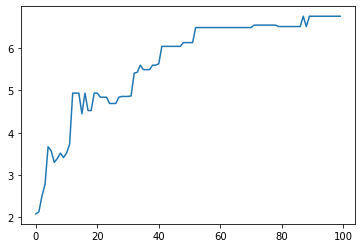

In [42]:
plt.plot(best_perf)